<a href="https://colab.research.google.com/github/JakobRobnik/periodax/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this tutorial we will explore how the `periodax` package works. We will start with the standard Lomb-Scargle periodogram to get familiar with the syntax. Then we will show how to
- do roboust p-value calculation
- do periodogram in the presence of correlated Gaussian noise
- go beyond the likelihood-ratio test statistic and compute the Bayes factor

First, let's clone the package from github:

In [1]:
!git clone https://github.com/JakobRobnik/periodax.git

Cloning into 'periodax'...
remote: Enumerating objects: 685, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 685 (delta 4), reused 2 (delta 0), pack-reused 670
Receiving objects: 100% (685/685), 18.92 MiB | 13.27 MiB/s, done.
Resolving deltas: 100% (388/388), done.


And do some imports:

In [10]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from periodax.LombScargle.periodogram import lomb_scargle, null_signal_template, fit
from periodax.LombScargle import drw

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

The package relies on Jax, for more information see [here](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html). The syntax is essentially that of NumPy.

# Lomb-Scargle periodogram

Let's simulate some simple data:

In [3]:
time = jnp.arange(100) #equally spaced time series

# noise
rng_key = jax.random.key(42)
key_err, key_noise = jax.random.split(rng_key)
err = jnp.abs(jax.random.normal(key_err, shape = time.shape)) # randomly generate some errorbars
noise = jax.random.normal(key_noise, shape = time.shape) * err # independent Gaussian noise with the given errorbars

# inject some signal
period = 11. # injected period of the signal
signal = jnp.sin(0.4 + 2 * jnp.pi * time / period) * 0.12
data = noise + signal

And visualize it:

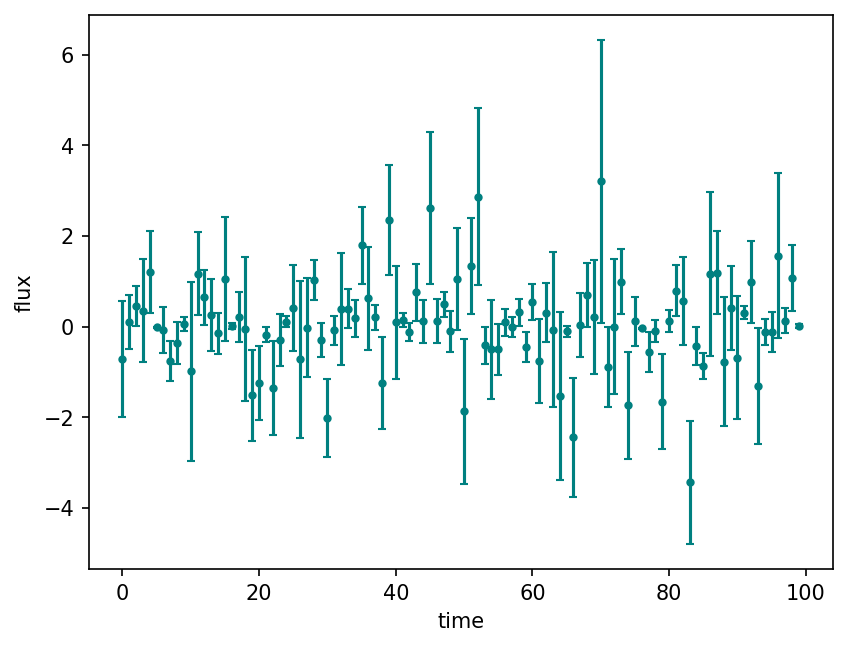

In [4]:
plt.errorbar(time, data, yerr= err, fmt = '.', capsize = 2., color = 'teal')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

Let's pass the data to `periodax`, which gives us a function for computing the periodogram:

In [5]:
compute_periodogram = lomb_scargle(time, data, floating_mean= True, sqrt_cov= err)


`sqrt_cov` is the square root of the covariance matrix. If noise is uncorrelated these are simply data errors. We will say more about this later.

We would now like to compute the periodogram on a grid of trial frequencies:

In [6]:
freq = jnp.arange(1, len(time)//2) / len(time) # 1/T, 2/T, ... Nyquist frequency

In Jax this operation can easily be parallelized with `jax.vmap` or `jax.pmap`, we will here use `vmap` because this operation is not expensive and we are using a single device:

In [7]:
parallelized_compute_periodogram = jax.vmap(compute_periodogram)

Let's compute the periodogram:

In [8]:
score, amp = parallelized_compute_periodogram(freq)

The output are the periodogram scores at each frequency ($\chi^2$ at the optimal amplitudes) and the optimal amplitudes.

Let's visualize the results:

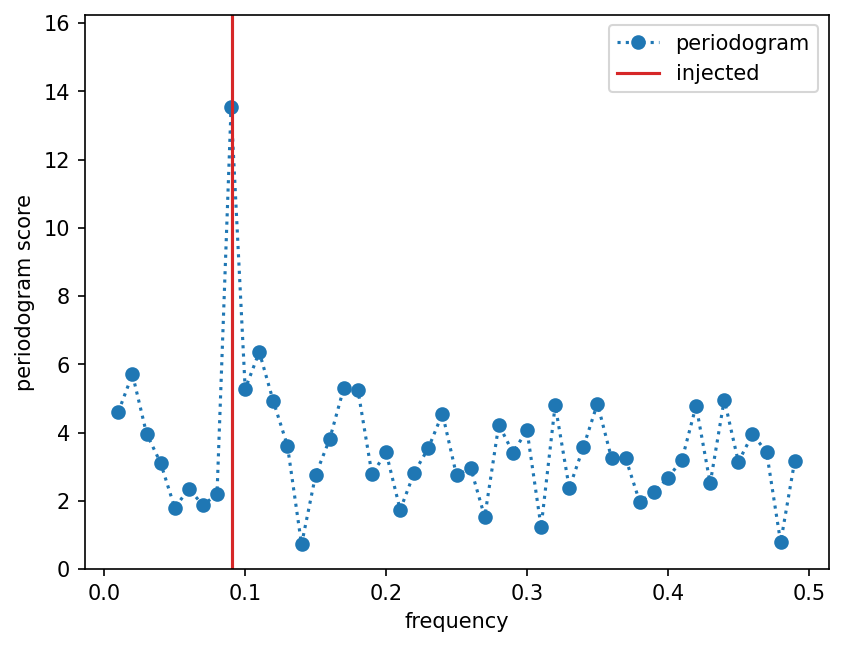

In [9]:
plt.plot(freq, score, 'o:', label = 'periodogram')
plt.plot(jnp.ones(2) / period, [0., jnp.max(score) * 2], '-', color = 'tab:red', label = 'injected')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('periodogram score')
plt.ylim(0, jnp.max(score) * 1.2)
plt.show()

The injected frequency was correctly retrieved. We can also visualize the best fit to the data:

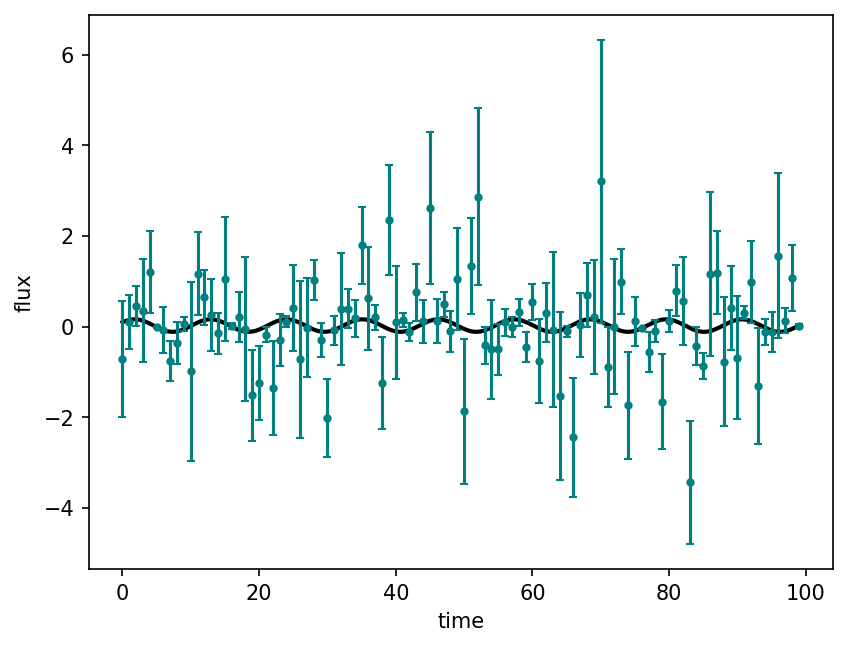

In [12]:
# best fit model
t = jnp.linspace(jnp.min(time), jnp.max(time), 1000)
ibest = jnp.argmax(score) # index of the highest score
model = fit(t, freq[ibest], amp[ibest])
plt.plot(t, model, color = 'black', lw = 2, label= 'model')

# data
plt.errorbar(time, data, yerr= err, fmt = '.', capsize = 2., color = 'teal')

plt.xlabel('time')
plt.ylabel('flux')
plt.show()


# Correlated noise




We will now take the correlated Gaussian noise. For concreteness, we will take damped random walk, which is stationary noise with exponentially decaying correlation function. Let's compute the covariance matrix:

In [13]:
cov = drw.covariance(time, drw.kernel(1., 20.), err)


Where we have added the squared measurement errors on the diagonal. Let's simulate the noise:

In [14]:
def gauss_noise(key):
    return jnp.linalg.cholesky(cov) @ jax.random.normal(key, shape= (cov.shape[0], ))

data = gauss_noise(rng_key)


And visualize the data:

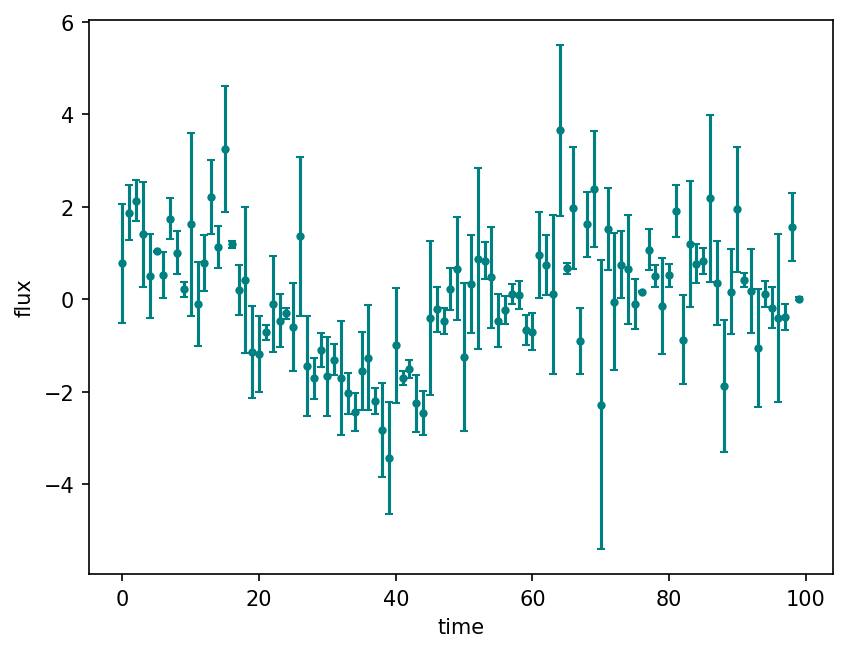

In [15]:
plt.errorbar(time, data, yerr= err, fmt = '.', capsize = 2., color = 'teal')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

As can be seen, there are now correlations in the data. Let's again add the signal:

In [16]:
data += 3 * signal

As before, we compute the periodogram, this time passing it the square root of the covariance matrix:

In [17]:
sqrt_cov = jnp.linalg.cholesky(cov) # square root of covariance matrix
compute_periodogram = lomb_scargle(time, data, floating_mean= True, sqrt_cov= sqrt_cov)

parallelized_compute_periodogram = jax.vmap(compute_periodogram)
score, amp = parallelized_compute_periodogram(freq)

And we can see that the signal is recovered:

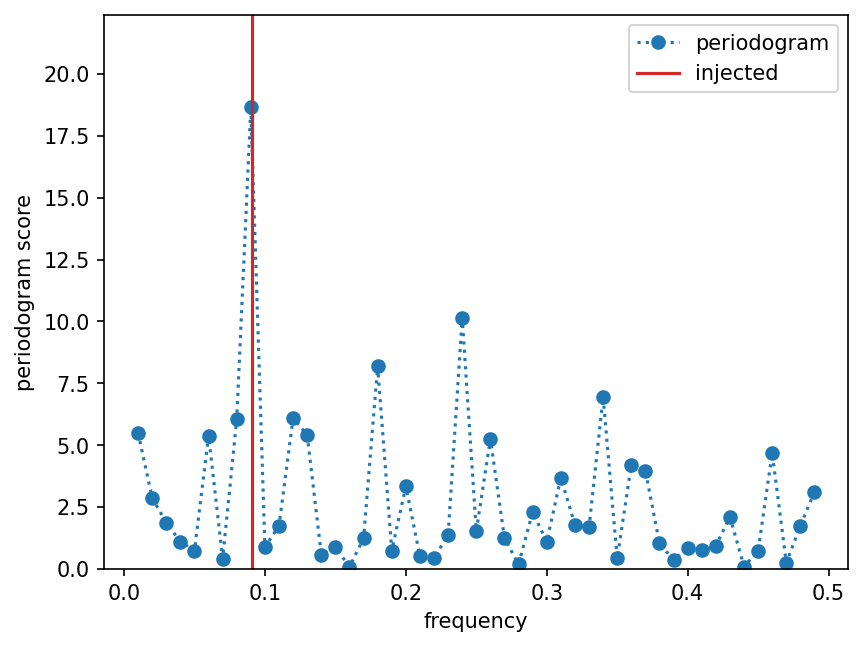

In [18]:
plt.plot(freq, score, 'o:', label = 'periodogram')
plt.plot(jnp.ones(2) / period, [0., jnp.max(score) * 2], '-', color = 'tab:red', label = 'injected')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('periodogram score')
plt.ylim(0, jnp.max(score) * 1.2)
plt.show()

However, if we used the standard periodogram (without accounting for the noise correlations), the signal would have been completely covered by the noise peaks:

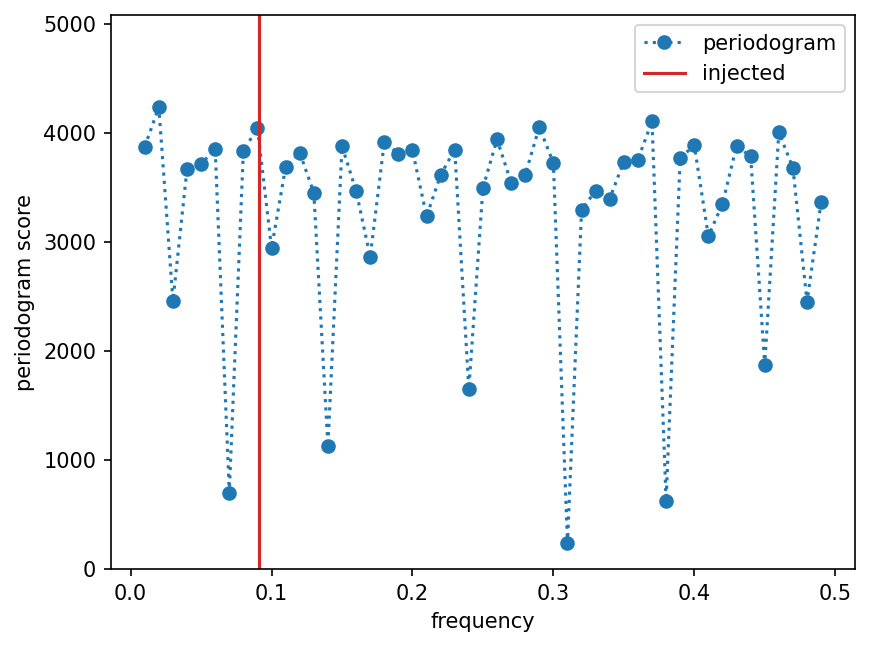

In [19]:
compute_periodogram = lomb_scargle(time, data, floating_mean= True, sqrt_cov= err)
parallelized_compute_periodogram = jax.vmap(compute_periodogram)
score, amp = parallelized_compute_periodogram(freq)

plt.plot(freq, score, 'o:', label = 'periodogram')
plt.plot(jnp.ones(2) / period, [0., jnp.max(score) * 2], '-', color = 'tab:red', label = 'injected')
plt.legend()
plt.xlabel('frequency')
plt.ylabel('periodogram score')
plt.ylim(0, jnp.max(score) * 1.2)
plt.show()

# Roboust null simulations

Suppose we now have 1000 light curves, each with 100 measurements. Let's simulate this dataset:

In [28]:
num_light_curves = 1000
keys = jax.random.split(rng_key, num_light_curves)
data = jax.vmap(gauss_noise)(keys) # use vmap to simulate multiple datasets at once
data.shape

(1000, 100)

We search for periodicity in each of them, and collect the best score for each light curve:

In [29]:
def best_score(data):
    compute_periodogram = lomb_scargle(time, data, floating_mean= True, sqrt_cov= sqrt_cov)
    parallelized_compute_periodogram = jax.vmap(compute_periodogram)
    return jnp.max(parallelized_compute_periodogram(freq)[0])

scores = jax.vmap(best_score)(data)

Let's visualize the distribution of these best scores:

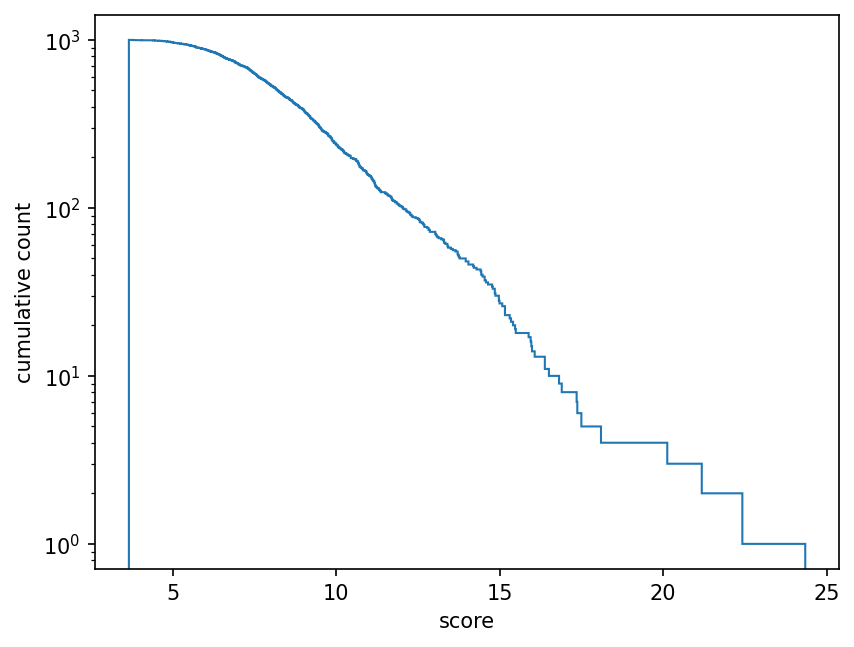

In [34]:
plt.hist(scores, cumulative= -1, histtype= 'step', bins = len(scores))
plt.xlabel('score')
plt.ylabel('cumulative count')
plt.yscale('log')
plt.show()

Naturally we would like to know weather we have detected something statistically significant or is this just noise (here we know that the simulations were noise-only, but in reality we wouldn't know that).
This is where the null signal template comes in. We take the dataset that we have and repeat the same procedure, this time switching the sinusoidal template with the null template:

In [31]:
def best_score_nst(data, rng_key):
    compute_periodogram = lomb_scargle(time, data, floating_mean= True, sqrt_cov= sqrt_cov, temp_func= null_signal_template(rng_key, 1000))
    parallelized_compute_periodogram = jax.vmap(compute_periodogram)
    return jnp.max(parallelized_compute_periodogram(freq)[0])

nst_keys = jax.random.split(jax.random.key(12), num_light_curves)
scores_nst = jax.vmap(best_score_nst)(data, nst_keys)

The null signal template runs act as effective null simulations. Let's compare the distribution of best scores, using true and null templates:

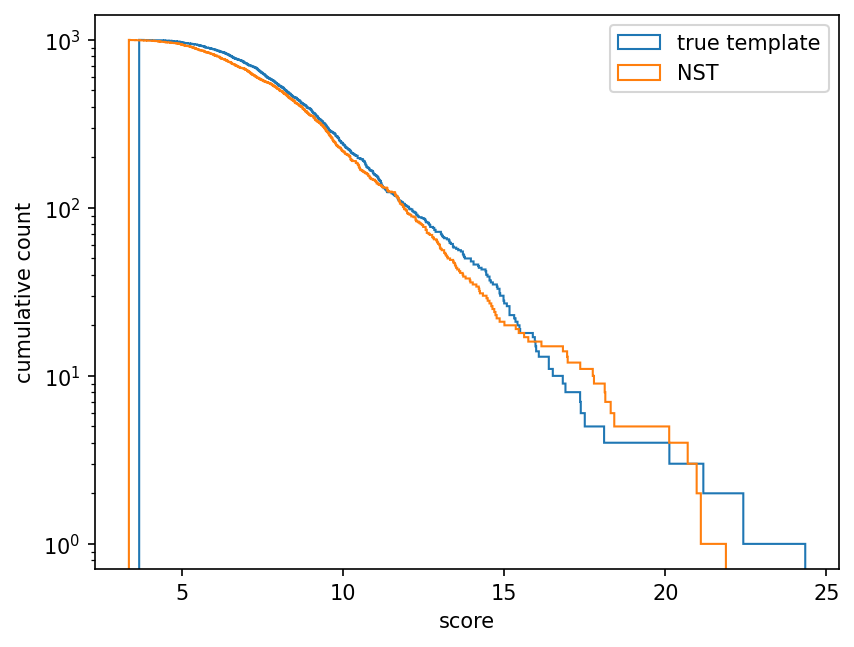

In [33]:
plt.hist(scores, cumulative= -1, histtype= 'step', bins = len(scores), label= 'true template')
plt.hist(scores_nst, cumulative= -1, histtype= 'step', bins = len(scores), label= 'NST')
plt.xlabel('score')
plt.ylabel('cumulative count')
plt.legend()
plt.yscale('log')
plt.show()

We can see that the two distributions are the same (up to finite sample size noise), so we conclude that we have not detected genuine signal.